In [1]:
import os
path = os.getcwd()
print("The path to this notebook is:", path)

import numpy as np
os.chdir("/home/ucecabj/Desktop/pyMFI_git")
# from pyMFI import MFI_dev_x_per_x_nonper as MFI
from pyMFI import MFI
from pyMFI import run_plumed
import pickle
import matplotlib.pyplot as plt

The path to this notebook is: /home/ucecabj/Desktop/pyMFI_git/pyMFI


### Attempt to make 2D langevin periodic data

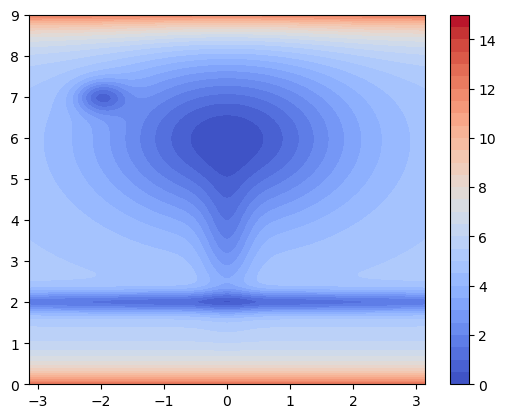

300
(300, 200)
0.00012133508825818318


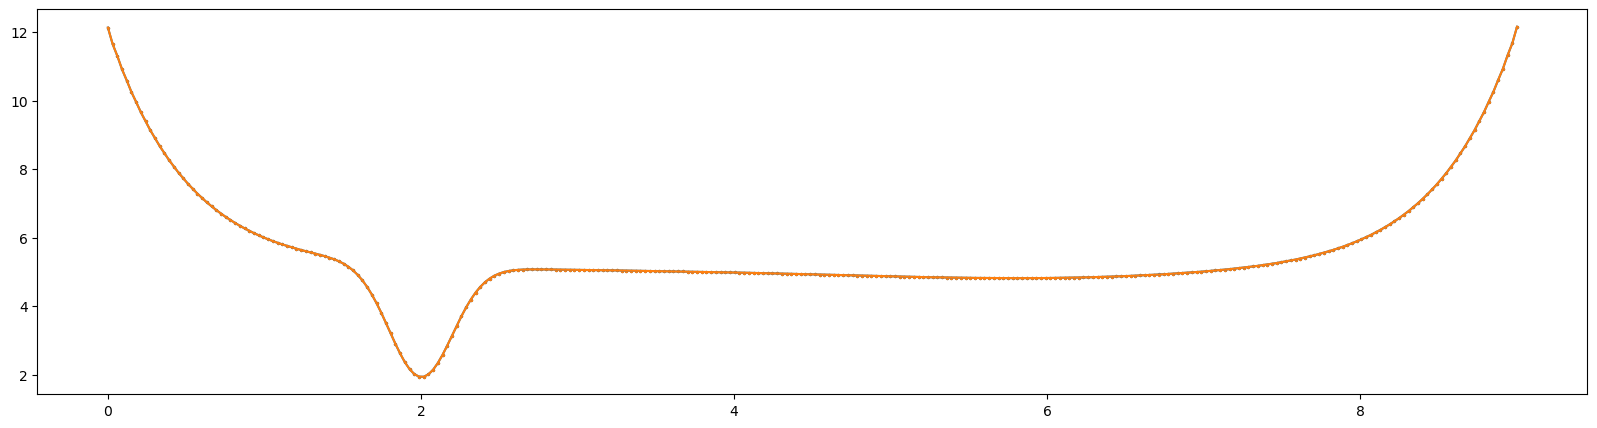

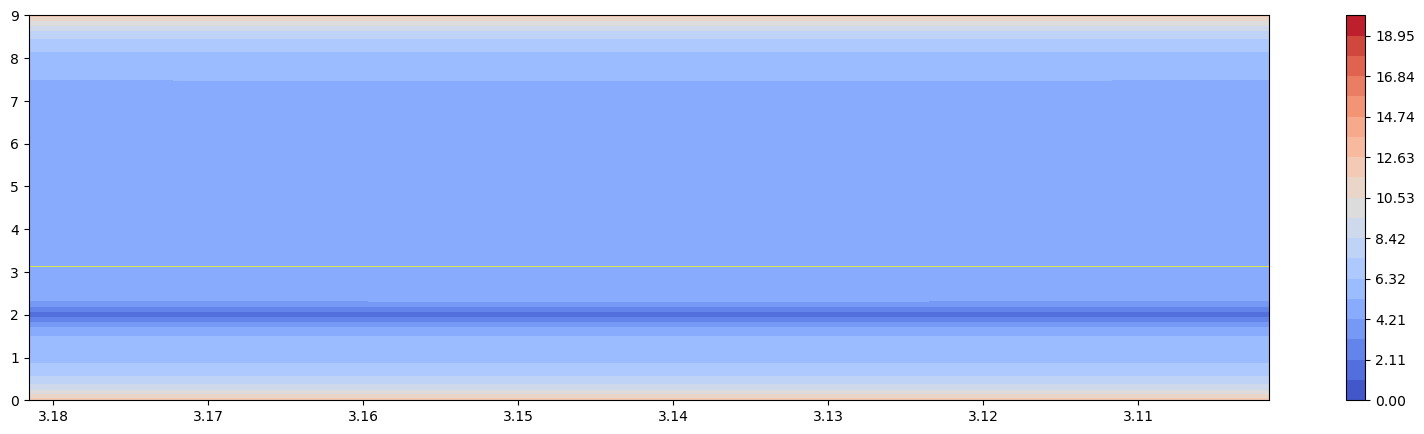

In [310]:
min_grid = np.array((-np.pi, 0))
max_grid = np.array((np.pi, 9))

nbins = np.array((300,200))

x = np.linspace(min_grid[0], max_grid[0], 200)
y = np.linspace(min_grid[1], max_grid[1], 300)

X, Y = np.meshgrid(x, y)

Z = -4*np.exp(-np.square(X-0)/(2*4)**2 - 2*np.square(Y-2)/(2*0.2)**2) - 2*np.exp(-np.square(X-0)/(2*0.2)**2 - 2*np.square(Y-3.5)/(2*1)**2) - 5*np.exp(-np.square(X-0)/(2*1)**2 - np.square(Y-6)/(2*1)**2) - 3*np.exp(-np.square(X+2)/(2*0.2)**2 - np.square(Y-7)/(2*0.2)**2) - 3*np.exp(-np.square(X+2-2*np.pi)/(2*0.2)**2 - np.square(Y-7)/(2*0.2)**2) + np.exp(-Y+1)**2 + np.exp(Y-8)**2
Z = Z - np.min(Z)

Z_str = "-2*exp(-(x/8)^2-((y-2)/0.4)^2)-exp(-(x/0.4)^2-((y-3.5)/2)^2)-2.5*exp(-(x/2)^2-((y-6)/2)^2)-1.5*exp(-((x+2)/0.4)^2-((y-7)/0.4)^2)+exp(-y+1)^2+exp(y-8)^2"

plt.contourf(X, Y, Z, levels=np.linspace(0,15,31), cmap="coolwarm")
plt.colorbar(); plt.show()

grad_y, grad_x = np.gradient(Z, (max_grid[0] - min_grid[0])/(nbins[1]-1), (max_grid[1] - min_grid[1])/(nbins[0]-1))

[X, Y, FES] = FFT_intg_2D(grad_x, grad_y, min_grid=min_grid, max_grid=max_grid, periodic_x=1, periodic_y=0)


print(len(FES[:,0]))
print(np.shape(FES))


print(np.sum(abs(FES[:,0] - FES[:,-1]))/len(FES[:,-1]))


plt.figure(figsize=(20,5)); plt.plot(y, FES[:,0]); plt.scatter(y, FES[:,0],s=2); plt.plot(y, FES[:,-1]); plt.scatter(y, FES[:,-1],s=2); plt.show()

plt.figure(figsize=(20,5))
plt.contourf(X,Y,FES, levels=np.linspace(0,20,20), cmap="coolwarm")
plt.contourf(X+2*np.pi,Y,FES, levels=np.linspace(0,20,20), cmap="coolwarm")

plt.colorbar(); plt.plot([1,4],[np.pi, np.pi], c="yellow", linewidth=0.5); 
# plt.xlim(2,4); 
plt.xlim(np.pi+0.04,np.pi-0.04)
plt.show()


In [3]:
run_plumed.run_langevin2D(simulation_steps=100_000,
                   analytical_function=Z_str, periodic_f="NO",
                   initial_position_x=0.0, initial_position_y=0.0, temperature=1, time_step=0.005,
                   grid_min_x=-np.pi, grid_max_x=np.pi, grid_min_y=-2, grid_max_y=12, grid_bin_x=200,
                   grid_bin_y=200,
                   gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=1, biasfactor=50, gaus_pace=40,
                   hp_centre_x=0.0, hp_centre_y=0.0, hp_kappa_x=0, hp_kappa_y=0,
                   lw_centre_x=0.0, lw_centre_y=0.0, lw_kappa_x=0, lw_kappa_y=0,
                   uw_centre_x=0.0, uw_centre_y=0.0, uw_kappa_x=0, uw_kappa_y=0,
                   position_pace=0, file_extension="_test_per")

starting simulation...


terminate called after throwing an instance of 'PLMD::Plumed::ExceptionError'
  what():  
+++ PLUMED error
+++ at Grid.cpp:170, function PLMD::GridBase::index_t PLMD::GridBase::getIndex(const std::vector<unsigned int>&) const
+++ message follows +++
ERROR: the system is looking for a value outside the grid along the 0 (p.x) index!
Aborted (core dumped)


### Data from Francesco

In [3]:
os.chdir("/home/ucecabj/Desktop/Fra_data")

min_grid = np.array((0,-np.pi))
max_grid = np.array((10,np.pi))
nbins = np.array((300,600))
x = np.linspace(min_grid[0], max_grid[0], nbins[1])
y = np.linspace(min_grid[1], max_grid[1], nbins[0])
X, Y = np.meshgrid(x, y)

In [3]:
# for i in range(1,4):
#     if i != 8:
#         HILLS = MFI.load_HILLS_2D("HILLS_" + str(i))
#         plt.scatter(HILLS[:,1], HILLS[:,2],s=1)

In [308]:

### Integration using Fast Fourier Transform (FFT integration) in 2D
def FFT_intg_2D(FX, FY, min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), nbins=0, periodic_x=0, periodic_y=0):
	"""2D integration of force gradient (FX, FY) to find FES using Fast Fourier Transform.

	Args:
		FX (array of size (nbins[0], nbins[1])): CV1 component of the Mean Force.
		FY (array of size (nbins[0], nbins[1])): CV1 component of the Mean Force.
		min_grid (array, optional): Lower bound of the simulation domain. Defaults to np.array((-np.pi, -np.pi)).
		min_grid (array, optional): Upper bound of the simulation domain. Defaults to np.array((np.pi, np.pi)).
		nbins (int, optional): number of bins in CV2,CV1. Defaults to 0. When nbins=0, nbins will take the shape of FX.

	Returns:
		X: array of size (nbins[0], nbins[1]) - CV1 meshgrid positions
		Y: array of size (nbins[0], nbins[1]) - CV2 meshgrid positions
		fes: array of size (nbins[0], nbins[1]) - Free Energy Surface
	"""
	if hasattr(nbins, "__len__") == False: nbins = np.shape(FX)        
	
	gridx = np.linspace(min_grid[0], max_grid[0], nbins[1])
	gridy = np.linspace(min_grid[1], max_grid[1], nbins[0])
	grid_spacex = (max_grid[0] - min_grid[0]) / (nbins[1] - 1)
	grid_spacey = (max_grid[1] - min_grid[1]) / (nbins[0] - 1)
	X, Y = np.meshgrid(gridx, gridy)
  
	#If system is non-periodic, make (anti-)symmetic copies so that the system appears symmetric/
	
	# if periodic_x == 0 or periodic_y == 0:
	# 	nbins = np.array((nbins[0]*2, nbins[1]*2))
	# 	FX = np.block([[-FX[:,::-1],FX],[-FX[::-1,::-1],FX[::-1,:]]])
	# 	FY = np.block([[FY[:,::-1],FY],[-FY[::-1,::-1],-FY[::-1,:]]])

	if periodic_x == 0:
		nbins = np.array((nbins[0], nbins[1]*2))
		FX = np.block([[-FX[:,::-1],FX]])
		FY = np.block([[FY[:,::-1],FY]])		
 
	if periodic_y == 0:
		nbins = np.array((nbins[0]*2, nbins[1]))
		FX = np.block([[FX],[FX[::-1,:]]])
		FY = np.block([[FY],[-FY[::-1,:]]])


	# Calculate frequency
	freq_1dx = np.fft.fftfreq(nbins[1], grid_spacex)
	freq_1dy = np.fft.fftfreq(nbins[0], grid_spacey)
 
	# print(np.max(freq_1dx), np.min(freq_1dx))
	# print(nbins[0], max_grid[0] , min_grid[0], nbins[1] - 1)
	# print(nbins[0], grid_spacey)
 
	freq_x, freq_y = np.meshgrid(freq_1dx, freq_1dy)
	freq_hypot = np.hypot(freq_x, freq_y)
	freq_sq = np.where(freq_hypot != 0, freq_hypot ** 2, 1E-10)
	# FFTransform and integration
 
	# print(np.shape(np.fft.fft2(FX)), np.shape(freq_x), np.shape(freq_sq))
	# print(np.min(np.fft.fft2(FX)), np.min(freq_x), np.min(freq_sq))
	# print(np.max(np.fft.fft2(FX)), np.max(freq_x), np.max(freq_sq))

	fourier_x = (np.fft.fft2(FX) * freq_x) / (2 * np.pi * 1j * freq_sq)
	fourier_y = (np.fft.fft2(FY) * freq_y) / (2 * np.pi * 1j * freq_sq)
	# Reverse FFT
	fes_x = np.real(np.fft.ifft2(fourier_x))
	fes_y = np.real(np.fft.ifft2(fourier_y))
	# Construct whole FES
	fes = fes_x + fes_y
	
	# #if non-periodic, cut FES back to original domain.
	if periodic_x == 0: fes = fes[:,int(nbins[1]/2):]
	if periodic_y == 0: fes = fes[:int(nbins[0]/2),:]

	fes = fes - np.min(fes)
	return [X, Y, fes]

Simulation: 1
|151/302|==> Average Mean Force Error: 481.15559410217065
|302/302|==> Average Mean Force Error: 447.453541250396
Simulation: 2
|415/830|==> Average Mean Force Error: 458.3343283631327
|830/830|==> Average Mean Force Error: 407.5634068697078
Simulation: 3
|612/1225|==> Average Mean Force Error: 439.86331038168146
|1224/1225|==> Average Mean Force Error: 427.2793500874029
Simulation: 4
|683/1367|==> Average Mean Force Error: 430.46882612237283
|1366/1367|==> Average Mean Force Error: 406.2865763364857
Simulation: 6
|627/1255|==> Average Mean Force Error: 440.81512259138316
|1254/1255|==> Average Mean Force Error: 431.3070380336355
Simulation: 7
|593/1187|==> Average Mean Force Error: 451.57501647196557
|1186/1187|==> Average Mean Force Error: 423.3216836346475
Simulation: 9
|555/1110|==> Average Mean Force Error: 436.2335836567975
|1110/1110|==> Average Mean Force Error: 419.9308247853271


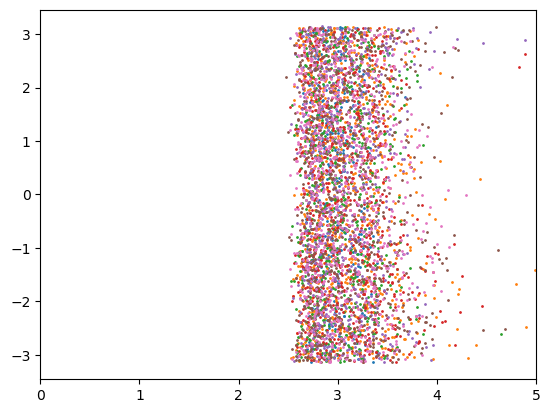

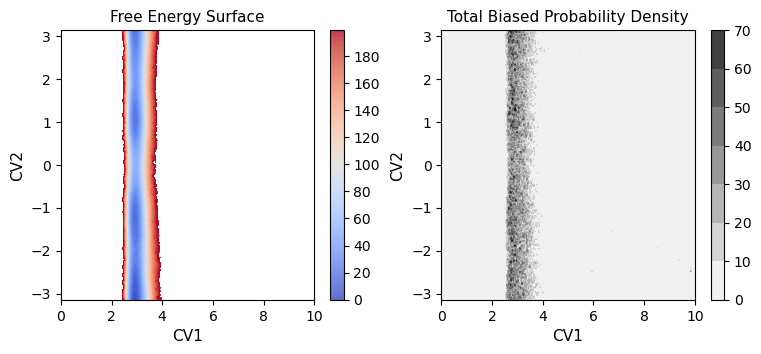

In [4]:
master = []

for simulation in [1,2,3,4,6,7,9]: 
    
    #Read the position and HILLS file
    print('Simulation: '+str(simulation))#, end="")
    [position_x, position_y] = MFI.load_position_2D(position_name="position_"+str(simulation))
    HILLS=MFI.load_HILLS_2D(hills_name="HILLS_"+str(simulation))
    len_hills = len(HILLS)
    
    plt.scatter(HILLS[:,1],HILLS[:,2],s=1)  
    # plt.scatter(position_x,position_y,s=1, c="r")  
        
    # COMPUTE Mean force and weight of the simulation
    results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.012, bw_y = 0.012, kT = 2.49, log_pace = len_hills//2, error_pace = len_hills//40, nhills=-1, min_grid=min_grid, max_grid=max_grid, nbins=nbins, FES_cutoff = 0, periodic_x=0, periodic_y=1)
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])   
  
  
# print(np.min(Ftot_x))
# plt.contourf(X,Y,Ftot_y)
plt.xlim(0,5)
plt.show()
# [X, Y, FES] = FFT_intg_2D(Ftot_x, Ftot_y, min_grid=min_grid, max_grid=max_grid, periodic_x=0, periodic_y=1)



#  #Patch
[Ftot_den_patch, Ftot_den2_patch, Ftot_x_patch, Ftot_y_patch, ofv_num_x_patch, ofv_num_y_patch] = MFI.patch_2D(master)

# #integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x_patch, Ftot_y_patch, min_grid=min_grid, max_grid=max_grid, periodic_x=0, periodic_y=0)

MFI.save_pkl([X,Y,FES], "x_y_fes.pkl")

# plt.contourf(X,Y,FES); plt.colorbar()
# plt.show()

# Plot Recap
MFI.plot_patch_2D(X, Y, FES, Ftot_den_patch,lim=200)

In [5]:
MFI.save_pkl([Ftot_x_patch, Ftot_y_patch], "F_patch_fra_data_ext_grid.pkl")
# [Ftot_x_patch, Ftot_y_patch] = MFI.load_pkl("F_patch_fra_data.pkl")



(300, 600)
600
0.13391964347999621


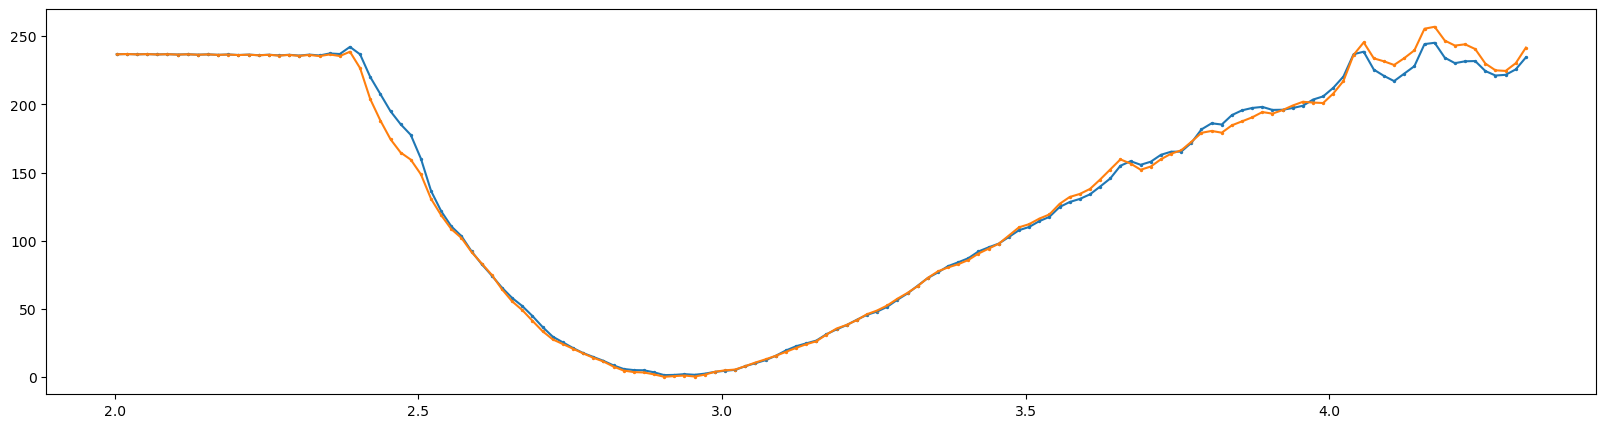

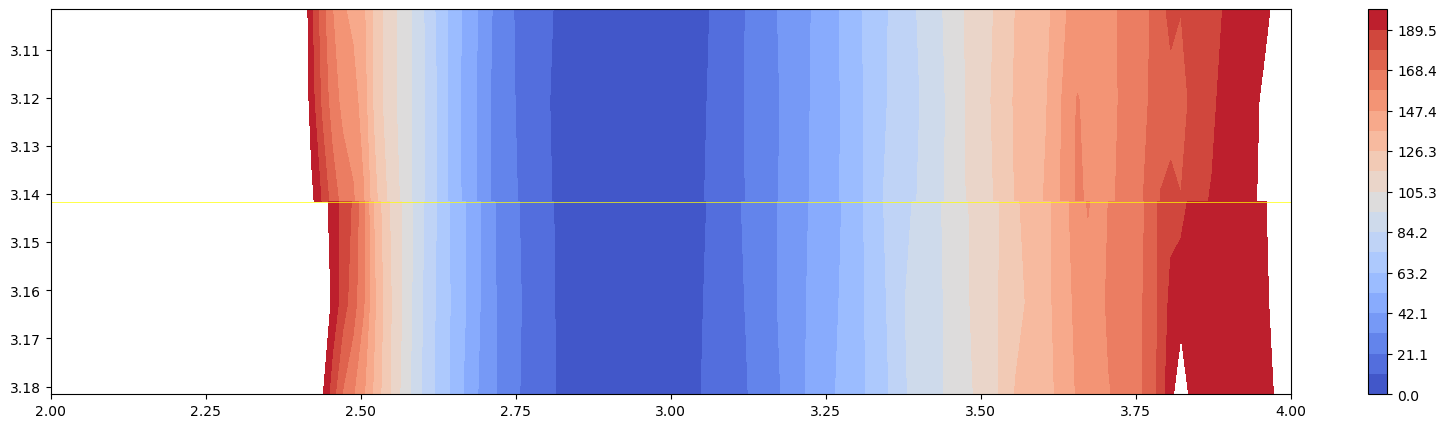

In [10]:
[Ftot_x_patch, Ftot_y_patch] = MFI.load_pkl("F_patch_fra_data_ext_grid.pkl")
#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x_patch, Ftot_y_patch, min_grid=min_grid, max_grid=max_grid, periodic_x=0, periodic_y=1)

n_plt = 1

# FX = np.block([[FX],[FX[::-1,:]]])
# FY = np.block([[FY],[-FY[::-1,:]]])

# FX = np.block([[-FX[:,::-1],FX]])
# FY = np.block([[FY[:,::-1],FY]])

print(np.shape(FES))
print(len(FES[0, :]))

FES_s = FES[:, 120:260]
X_s = X[:, 120:260]

print(np.sum(abs(FES_s[0,:] - FES_s[-1, :])/FES_s[-1, :])/len(FES_s[-1, :]))


plt.figure(figsize=(20,5))
plt.plot(x[120:260], FES_s[0, :])
plt.scatter(x[120:260], FES_s[0, :],s=2)
plt.plot(x[120:260], FES_s[-1, :])
plt.scatter(x[120:260], FES_s[-1, :],s=2)
# plt.xlim(2,4);
plt.show()

# X = np.block([[X,X]])
# Y = np.block([[Y,Y+2*np.pi]])
# FES = np.block([[FES[:,:300][:,::-1],FES[:,300:]]])


plt.figure(figsize=(20,5))
if n_plt == 1:
    plt.contourf(X,Y,FES, levels=np.linspace(0,200,20), cmap="coolwarm")
    plt.contourf(X,Y+2*np.pi,FES, levels=np.linspace(0,200,20), cmap="coolwarm")
    
if n_plt == 2:
    plt.contourf(X,Y,Ftot_den, levels=np.linspace(0,15,20), cmap="coolwarm")
    plt.contourf(X,Y+2*np.pi,Ftot_den, levels=np.linspace(0,15,20), cmap="coolwarm")

if n_plt == 3:
    plt.contourf(X,Y,Ftot_x_patch, levels=np.linspace(-650,650,20), cmap="coolwarm")
    plt.contourf(X,Y+2*np.pi,Ftot_x_patch, levels=np.linspace(-650,650,20), cmap="coolwarm")

if n_plt == 4:
    plt.contourf(X,Y,Ftot_y_patch, levels=np.linspace(-450,450,20), cmap="coolwarm")
    plt.contourf(X,Y+2*np.pi,Ftot_y_patch, levels=np.linspace(-450,450,20), cmap="coolwarm")
#
if n_plt == 5:
    # plt.contourf(X[:,5:25],Y[:,5:25],FES[:,5:25], levels=np.linspace(0,200,20), cmap="coolwarm")
    plt.contourf(X,Y,FES, levels=np.linspace(0,300,20), cmap="coolwarm")


plt.colorbar(); plt.plot([1,4],[np.pi, np.pi], c="yellow", linewidth=0.5); 
plt.xlim(2,4); plt.ylim(np.pi+0.04,np.pi-0.04)
plt.show()

(300, 600)
600
3.439892226500448


/usr/ulocal/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/ulocal/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


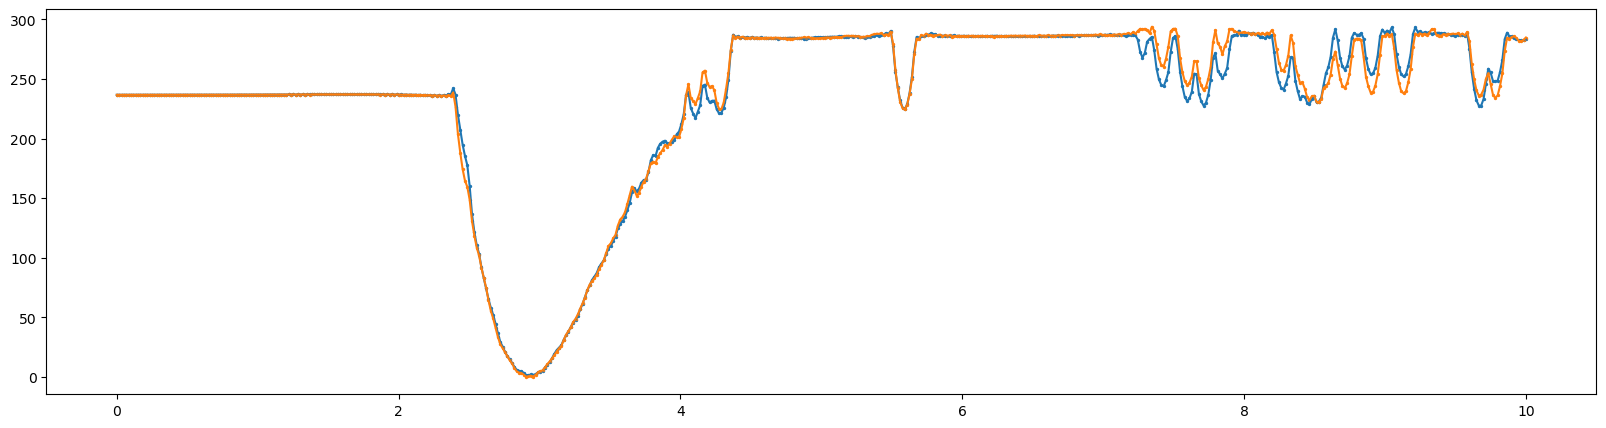

/usr/ulocal/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


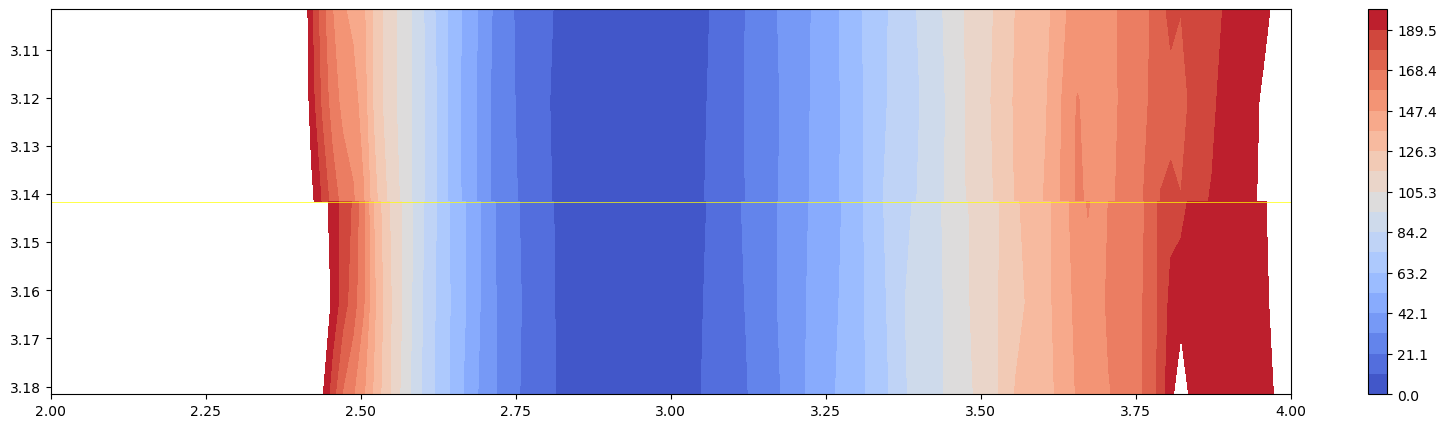

In [294]:
[Ftot_x_patch, Ftot_y_patch] = MFI.load_pkl("F_patch_fra_data.pkl")
#integration on a periodic domain
[X, Y, FES] = FFT_intg_2D(Ftot_x_patch, Ftot_y_patch, min_grid=min_grid, max_grid=max_grid, periodic_x=0, periodic_y=1)


print(np.shape(FES))
print(len(FES[0, :]))

print(np.sum(abs(FES[0,:] - FES[-1, :]))/len(FES[-1, :]))


plt.figure(figsize=(20,5)); plt.plot(gridx, FES[0, :]); plt.scatter(gridx, FES[0, :],s=2); plt.plot(gridx, FES[-1, :]); plt.scatter(gridx, FES[-1, :],s=2); plt.show()

plt.figure(figsize=(20,5))
plt.contourf(X,Y,FES, levels=np.linspace(0,200,20), cmap="coolwarm")
plt.contourf(X,Y+2*np.pi,FES, levels=np.linspace(0,200,20), cmap="coolwarm")

plt.colorbar(); plt.plot([1,4],[np.pi, np.pi], c="yellow", linewidth=0.5); 
plt.xlim(2,4); plt.ylim(np.pi+0.04,np.pi-0.04)
plt.show()

In [281]:

[Ftot_x_patch, Ftot_y_patch] = MFI.load_pkl("F_patch_fra_data.pkl")

print(np.shape(Ftot_x_patch))

FX, FY = Ftot_x_patch, Ftot_y_patch

periodic_x=1
periodic_y=1

nbins = np.shape(FX)        
	
gridx = np.linspace(min_grid[0], max_grid[0], nbins[1])
gridy = np.linspace(min_grid[1], max_grid[1], nbins[0])
grid_spacex = (max_grid[0] - min_grid[0]) / (nbins[1] - 1)
grid_spacey = (max_grid[1] - min_grid[1]) / (nbins[0] - 1)
X, Y = np.meshgrid(gridx, gridy)

#If system is non-periodic, make (anti-)symmetic copies so that the system appears symmetric/

# if periodic_x == 0 or periodic_y == 0:
# 	nbins = np.array((nbins[0]*2, nbins[1]*2))
# 	FX = np.block([[-FX[:,::-1],FX],[-FX[::-1,::-1],FX[::-1,:]]])
# 	FY = np.block([[FY[:,::-1],FY],[-FY[::-1,::-1],-FY[::-1,:]]])
# 	X = np.block([[X,X],[X,X]])
# 	FY = np.block([[Y,Y],[Y,Y]])

if periodic_x == 0:
	nbins = np.array((nbins[0], nbins[1]*2))
	FX = np.block([[-FX[:,::-1],FX]])
	FY = np.block([[FY[:,::-1],FY]])		
	X = np.block([[X,X+gridx[-1]-gridx[0]]])		
	Y = np.block([[Y,Y]])		

if periodic_y == 0:
	nbins = np.array((nbins[0]*2, nbins[1]))
	FX = np.block([[FX],[FX[::-1,:]]])
	FY = np.block([[FY],[-FY[::-1,:]]])
	X = np.block([[X],[X]])		
	Y = np.block([[Y],[Y+2*np.pi]])


# Calculate frequency
freq_1dx = np.fft.fftfreq(nbins[1], grid_spacex)
freq_1dy = np.fft.fftfreq(nbins[0], grid_spacey)

# print(np.max(freq_1dx), np.min(freq_1dx))
# print(nbins[0], max_grid[0] , min_grid[0], nbins[1] - 1)
# print(nbins[0], grid_spacey)

freq_x, freq_y = np.meshgrid(freq_1dx, freq_1dy)
freq_hypot = np.hypot(freq_x, freq_y)
freq_sq = np.where(freq_hypot != 0, freq_hypot ** 2, 1E-50)
# FFTransform and integration

# print(np.shape(np.fft.fft2(FX)), np.shape(freq_x), np.shape(freq_sq))
# print(np.min(np.fft.fft2(FX)), np.min(freq_x), np.min(freq_sq))
# print(np.max(np.fft.fft2(FX)), np.max(freq_x), np.max(freq_sq))

fourier_x = (np.fft.fft2(FX) * freq_x) / (2 * np.pi * 1j * freq_sq)
fourier_y = (np.fft.fft2(FY) * freq_y) / (2 * np.pi * 1j * freq_sq)
# Reverse FFT
fes_x = np.real(np.fft.ifft2(fourier_x))
fes_y = np.real(np.fft.ifft2(fourier_y))
# Construct whole FES
FES = fes_x + fes_y

# #if non-periodic, cut FES back to original domain.
# if periodic_x == 0: 
#     FES = FES[:,int(nbins[1]/2):]
#     X = X[:,int(nbins[1]/2):]
#     Y = Y[:,int(nbins[1]/2):]
# if periodic_y == 0: 
#     FES = FES[:int(nbins[0]/2),:]
#     X = X[:int(nbins[0]/2),:]
#     Y = Y[:int(nbins[0]/2),:]

FES = FES - np.min(FES)

print(np.shape(FES))

# print(np.sum(abs(FES[:,:600] - FES[:, 600:][:,::-1])))


FES = FES[:,600:]
X = X[:,:600]
Y = Y[:,:600]

print(np.sum(abs(FES[0,:] - FES[-1, :]))/len(FES[-1, :]))

plt.figure(figsize=(20,5))
plt.plot(gridx, FES[0, :])
plt.scatter(gridx, FES[0, :],s=2)
plt.plot(gridx, FES[-1, :])
plt.scatter(gridx, FES[-1, :],s=2)
# plt.xlim(2,4);
plt.show()

print(np.shape(X))
print(np.shape(Y))
print(np.shape(FES))

plt.figure(figsize=(20,5))
plt.contourf(X,Y,FES, levels=np.linspace(0,300,20), cmap="coolwarm"); 
plt.contourf(X,Y+2*np.pi,FES, levels=np.linspace(0,300,20), cmap="coolwarm"); plt.colorbar()

# plt.contourf(X,Y,FES, cmap="coolwarm"); plt.colorbar()

# plt.contourf(X,Y,FES, levels=np.linspace(0,200,20), cmap="coolwarm")
# plt.contourf(X,Y+2*np.pi,FES, levels=np.linspace(0,200,20), cmap="coolwarm")

plt.xlim(2,4);
# plt.xlim(56,58);
plt.ylim(np.pi-0.04,np.pi+0.04);plt.show()




(300, 600)
(300, 600)


ValueError: operands could not be broadcast together with shapes (300,600) (300,0) 

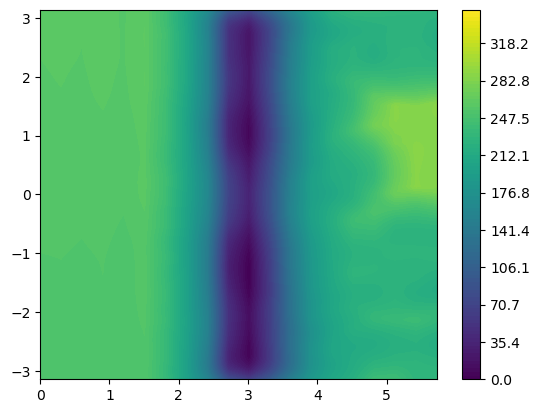

In [ ]:
import pickle

with open("x_y_fes.pkl", "rb") as fr:
	[X2,Y2,FES2] = pickle.load(fr)
 
plt.contourf(X2[:,:20],Y2[:,:20],FES2[:,:20], levels=np.linspace(0,350,100)); plt.colorbar()
plt.show()

In [103]:
def find_periodic_point(x_coord, y_coord, min_grid, max_grid, periodic_x, periodic_y):
	"""Finds periodic copies of input coordinates. First checks if systems is periodic. If not, returns input coordinate array. Next, it checks if each coordinate is within the boundary range (grid min/max +/- grid_ext). If it is, periodic copies will be made on the other side of the CV-domain. 
	
	Args:
		x_coord (float): CV1-coordinate
		y_coord (float): CV2-coordinate
		min_grid (list): list of CV1-minimum value of grid and CV2-minimum value of grid
		max_grid (list): list of CV1-maximum value of grid and CV2-maximum value of grid
		periodic_x (binary): Specifies if CV1 is periodic. value of 0 corresponds to non-periodic CV1; function will only return input coordinates. Value of 1 corresponds to periodic CV1; function will return input coordinates with periodic copies if appilcable.
		periodic_y (binary): Specifies if CV2 is periodic. value of 0 corresponds to non-periodic CV2; function will only return input coordinates. Value of 1 corresponds to periodic CV2; function will return input coordinates with periodic copies if appilcable.
	Returns:
		list: list of [x-coord, y-coord] pairs
	"""

	coord_list = []
	coord_list.append([x_coord, y_coord])
	
	if periodic_x == 1 or periodic_y == 1:
		# Use periodic extension for defining PBC
		grid_length = max_grid - min_grid
		grid_ext = (1 / 4) * grid_length

		# There are potentially 4 points, 1 original and 3 periodic copies, or less.

		copy_record = [0, 0, 0, 0]
		# check for x-copy
		if x_coord < min_grid[0] + grid_ext[0] and periodic_x == 1:
			coord_list.append([x_coord + grid_length[0], y_coord])
			copy_record[0] = 1
		elif x_coord > max_grid[0] - grid_ext[0] and periodic_x == 1:
			coord_list.append([x_coord - grid_length[0], y_coord])
			copy_record[1] = 1
		# check for y-copy
		if y_coord < min_grid[1] + grid_ext[1] and periodic_y == 1:
			coord_list.append([x_coord, y_coord + grid_length[1]])
			copy_record[2] = 1
		elif y_coord > max_grid[1] - grid_ext[1] and periodic_y == 1:
			coord_list.append([x_coord, y_coord - grid_length[1]])
			copy_record[3] = 1
		# check for xy-copy
		if sum(copy_record) == 2:
			if copy_record[0] == 1 and copy_record[2] == 1:
				coord_list.append([x_coord + grid_length[0], y_coord + grid_length[1]])
			elif copy_record[1] == 1 and copy_record[2] == 1:
				coord_list.append([x_coord - grid_length[0], y_coord + grid_length[1]])
			elif copy_record[0] == 1 and copy_record[3] == 1:
				coord_list.append([x_coord + grid_length[0], y_coord - grid_length[1]])
			elif copy_record[1] == 1 and copy_record[3] == 1:
				coord_list.append([x_coord - grid_length[0], y_coord - grid_length[1]])       
    
	return coord_list

In [114]:
min_grid = np.array((-np.pi, 0)); max_grid = np.array((np.pi, 9)); nbins = np.array((1000,800))
kT = 1; 
# bw = 0.1; bw2 = bw ** 2; bw_xy = bw

bw_x = 0.1; bw2_x = bw_x ** 2; 
bw_y = 0.1; bw2_y = bw_y ** 2; 
bw_xy = np.sqrt(bw_x * bw_y); bw2_xy = bw_xy ** 2

gridx = np.linspace(min_grid[0], max_grid[0], nbins[0]); gridy = np.linspace(min_grid[1], max_grid[1], nbins[1]); grid_space = np.array(((max_grid[0] - min_grid[0]) / (nbins[0]-1), (max_grid[1] - min_grid[1]) / (nbins[1]-1)))
X, Y = np.meshgrid(gridx, gridy); stride = 10; const = (1 / (bw_xy * np.sqrt(2 * np.pi) * stride))

data = [3,7]

data = find_periodic_point(x_coord=data[0], y_coord=data[1], min_grid=min_grid, max_grid=max_grid, periodic_x=1, periodic_y=1)

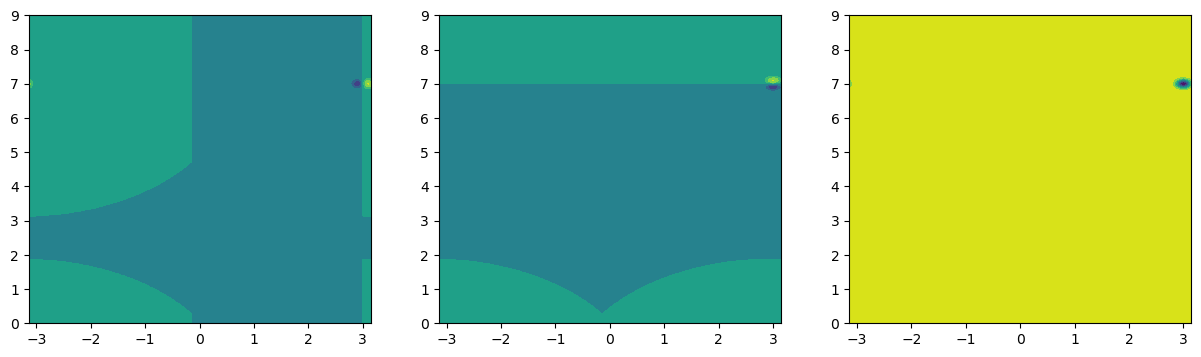

In [115]:
Fpbt_x = np.zeros_like(X)
Fpbt_y = np.zeros_like(X)
pb_t = np.zeros_like(X)

for j in range(len(data)):
    kernel_x = np.exp( - np.square(gridx - data[j][0]) / (2 * bw2_x)) * const #add constant here for less computations
    kernel_y = np.exp( - np.square(gridy - data[j][1]) / (2 * bw2_y))
    kernel = np.outer(kernel_y, kernel_x)
    kernel_x *= kT / bw2_xy #add constant here for less computations

    pb_t += kernel
    Fpbt_x += np.outer(kernel_y, np.multiply(kernel_x, (gridx - data[j][0])) )
    Fpbt_y += np.outer(np.multiply(kernel_y, (gridy - data[j][1])) , kernel_x )

plt.figure(figsize=(15,4)); plt.subplot(1,3,1); plt.contourf(X,Y,Fpbt_x)
plt.subplot(1,3,2); plt.contourf(X,Y,Fpbt_y)
X,Y,Z = MFI.FFT_intg_2D(Fpbt_x, Fpbt_y, min_grid=min_grid, max_grid=max_grid)
plt.subplot(1,3,3); plt.contourf(X,Y,Z); plt.show()

In [102]:
print(len(gridx))
print(len(gridy))

print(X[700,500])


1000
800
0.0031447373909805343


In [113]:
print(np.shape(Fpbt_x))
print(np.min(Fpbt_x)); print(np.min(Fpbt_y)); print(np.max(Fpbt_x)); print(np.max(Fpbt_y)); print(np.max(Z)); 

(800, 1000)
-2.415038770653408
-2.4127182359436516
2.415234200650629
2.4153471598537766
0.3983481519233918


In [97]:
print(np.shape(Fpbt_x))
print(np.min(Fpbt_x)); print(np.min(Fpbt_y)); print(np.max(Fpbt_x)); print(np.max(Fpbt_y)); print(np.max(Z)); 

(800, 1000)
-2.415138048817409
-2.4126587010239895
2.4151380488174086
2.4152875600642214
0.39824569790978553


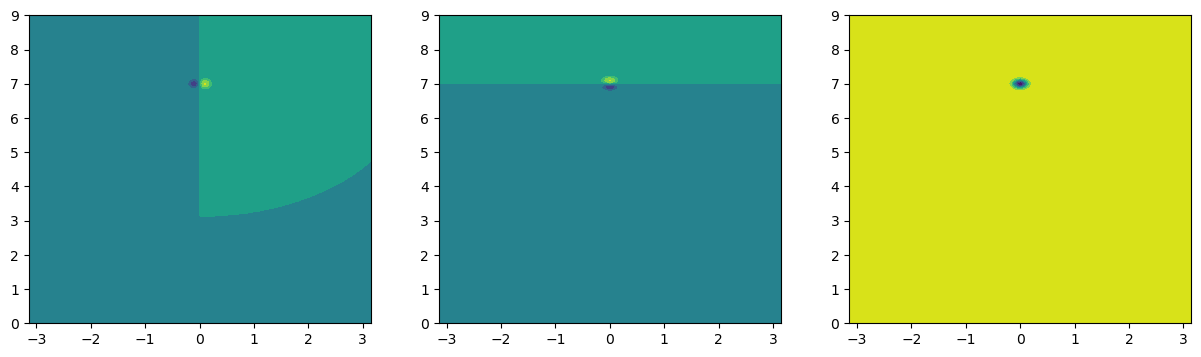

In [90]:
Fpbt_x = np.zeros_like(X)
Fpbt_y = np.zeros_like(X)
pb_t = np.zeros_like(X)

kernel_x = np.exp( - np.square(gridx - data[0]) / (2 * bw2)) * const #add constant here for less computations
kernel_y = np.exp( - np.square(gridy - data[1]) / (2 * bw2))
kernel = np.outer(kernel_y, kernel_x)
kernel_x *= kT / bw2 #add constant here for less computations

pb_t += kernel
Fpbt_x += np.outer(kernel_y, np.multiply(kernel_x, (gridx - data[0])) )
Fpbt_y += np.outer(np.multiply(kernel_y, (gridy - data[1])) , kernel_x )

plt.figure(figsize=(15,4)); plt.subplot(1,3,1); plt.contourf(X,Y,Fpbt_x)
plt.subplot(1,3,2); plt.contourf(X,Y,Fpbt_y)
X,Y,Z = MFI.FFT_intg_2D(Fpbt_x, Fpbt_y, min_grid=min_grid, max_grid=max_grid)
plt.subplot(1,3,3); plt.contourf(X,Y,Z); plt.show()

In [88]:
print(np.shape(Fpbt_x))
print(np.min(Fpbt_x)); print(np.min(Fpbt_y)); print(np.max(Fpbt_x)); print(np.max(Fpbt_y)); print(np.max(Z)); 

(1000, 1000)
-2.4181664299422927
-2.418314194297913
2.4181664299422923
2.418314194297913
0.39874506470797216


In [91]:
print(np.shape(Fpbt_x))
print(np.min(Fpbt_x)); print(np.min(Fpbt_y)); print(np.max(Fpbt_x)); print(np.max(Fpbt_y)); print(np.max(Z)); 

(800, 1000)
-2.415138048817409
-2.4126587010239895
2.4151380488174086
2.4152875600642214
0.39824569790978553


(800, 1000)
(800, 1000)
(800, 1000)


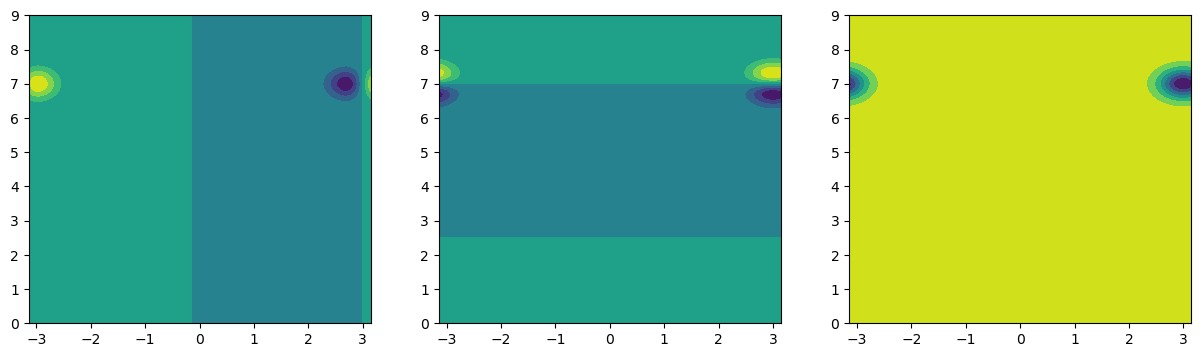

-1.9177450900941684
-1.917595789477885
1.9177366306382797
1.9173672056774598
0.9998728361354926


In [118]:
sigma_meta2_x = 0.1; sigma_meta2_y = 0.1; height_meta = 1
Fbias_x = np.zeros_like(X)
Fbias_y = np.zeros_like(X)

for j in range(len(data)):
    kernelmeta_x = np.exp( - np.square(gridx - data[j][0]) / (2 * sigma_meta2_x)) * height_meta
    kernelmeta_y = np.exp( - np.square(gridy - data[j][1]) / (2 * sigma_meta2_y))

    Fbias_x += np.outer(kernelmeta_y, np.multiply(kernelmeta_x, (gridx - data[j][0])) / sigma_meta2_x )
    Fbias_y += np.outer(np.multiply(kernelmeta_y, (gridy - data[j][1])) / sigma_meta2_y, kernelmeta_x )

print(np.shape(Fbias_x))
print(np.shape(Fbias_y))
print(np.shape(X))


plt.figure(figsize=(15,4)); plt.subplot(1,3,1); plt.contourf(X,Y,Fbias_x)
plt.subplot(1,3,2); plt.contourf(X,Y,Fbias_y)
X,Y,Z = MFI.FFT_intg_2D(Fbias_x, Fbias_y, min_grid=min_grid, max_grid=max_grid)
plt.subplot(1,3,3); plt.contourf(X,Y,Z); plt.show()

print(np.min(Fbias_x)); print(np.min(Fbias_y)); print(np.max(Fbias_x)); print(np.max(Fbias_y)); print(np.max(Z)); 
